In [407]:
import pandas as pd
import numpy as np
# Plots with high resolution
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150
import matplotlib.ticker as plticker

import matplotlib.pyplot as plt

In [408]:
def get_slu_mstats(df, runs=11):
    """"Compute memory statistics for a DataFrame holding SuperLU results.
        Omit first run.

    Args:
        df (pandas.dataFrame): 
        runs (int, optional): Number of runs.

    Returns:
        [Mean over total memory, Mean over LU memory]
    """
    l = 1
    u = l+runs-1
    return [df['Total MB'][l:u].mean(), df['LU MB'][l:u].mean()]
    

In [409]:
def get_slu_stats(df, spec, runs=11, l=1):
    """"Compute statistics for the columns 'spec' of a DataFrame holding SuperLU results.
        Omit first run for every thread.

    Args:
        df (pandas.dataFrame): 
        spec (str): Column specifier
        runs (int, optional): Number of runs.

    Returns:
        [Mean runtime, min, max, std deviation]
    """
    ret = []
    u = l+runs-1
    mean = df[spec][l:u].mean()
    mini = df[spec][l:u].min()
    maxi = df[spec][l:u].max()
    std = df[spec][l:u].std()
    return ([mean, mini, maxi, std])

In [410]:
def get_slumt_stats(df, spec, runs=11):
    """Compute statistics for the columns 'spec' of a DataFrame holding SuperLU_MT results.
       Omit first run for every thread.

    Args:
        df (pandas.dataFrame): 
        spec (str): Column specifier
        runs (int, optional): Number of runs.

    Returns:
        List with number of threads and list with corresponding statistics as list of list.
    """
    threads = []
    ret = []
    l = 1
    for i in range(int(df['#Threads'].min()), int(df['#Threads'].max())+1):
        threads.append(i)
        ret.append(get_slu_stats(df, spec, runs, l))
        # Update l and u
        l += runs
        
    return (threads, ret)

In [411]:
def get_speedups(tstats, t1=None):
    """"Return speedups for a given list of timing statistics (mean time over #threads).

    Args:
        tstats (list): Timing statistics
        t1 (float, optional): Serial time to refer the speedup to. If not given, we use the runtime using 1 thread.

    Returns:
        List of speedups.
    """
    sp = []
    if t1 is None:
        t1 = tstats[0][0] # Time for serial run
    # Todo: Check that provided t1 is a numerical value > 0.
    for i in [item[0] for item in tstats]:
        #print(i)
        sp.append(t1/i)
    
    return sp

In [412]:
from operator import itemgetter
def get_best_time(list1, list2, list3):
    """ Return min. value and the coresponding index over three lists.
        Todo: Pass arbitrary number of lists.... or list(list, list, ...,list)
        This is a basic implementation I have to admit. Someone might write it as one-liner.
    """
    # Create list containing (idx1, min_val1), (idx2, min_val2), ...
    # Than determine min value and the corresponding index. Than return the corresponding sublist.
    l = []
    l.append(min(enumerate(map(itemgetter(0), list1)), key=itemgetter(1)))
    l.append(min(enumerate(map(itemgetter(0), list2)), key=itemgetter(1)))
    l.append(min(enumerate(map(itemgetter(0), list3)), key=itemgetter(1)))
    i, j = min(enumerate(map(itemgetter(1), l)), key=itemgetter(1))
    return l[i]
    

In [413]:
def condense_df(df, runs=5):
    """"Condense DataFrame in the sense, that it holds the mean run time for a process grid, not the several individual run times.
        Omit first run for every process grid configuration.
        Assume no empty lines between blocks of fixed grid size.

    Args:
        df (pandas.dataFrame): 
        runs (int, optional): Number of runs for a fixed number of threads.

    Returns:
        DataFrame with mean timings in ms.
    """
    rows = []
    l = 1;
    u = l+runs-1
    for i in range(0,df.shape[0]/runs):
        rows.append((df['#MPI Procs'][l], df['nrow'][l], df['ncol'][l], df['pdgssvx_Abglobal'][l:u].mean()/1000))
        # Update l and u
        l += runs
        u = l+runs-1
        
    cols = ['#MPI Procs', 'nrows', 'ncols', 'time']
    return pd.DataFrame.from_records(rows, columns=cols)

In [414]:
def get_sludist_best_time(df):
    """
    Returns:
        (min time, [mpi procs, nrows, ncols])
    """
    ret = []
    t = df['time'].min()
    idx = df['time'].idxmin() # Idx of minimal value in column 'time'
    nrows = df['nrows'][idx]
    ncols = df['ncols'][idx]
    mpi = df['#MPI Procs'][idx]
    return (t, [mpi, nrows, ncols])
    

# Benchmark Results and Evaluation

See the `README.html` document for what this project is all about. Basically it holds three benchmarks to solve large sparse linear systems of form Ax=b using the libraries SuperLU, SuperLU_MT and SuperLU_DIST.

In the following, we analyse and evaluate the obtained results for a set of benchmark problems. We will investigate the metrics time to solution and memory footprint as well as strong scaling behaviour.

The benchmarks problem (i.e., the linear systems Ax=b) are obtained from HQP:

| Matrix       | Dim    | # Nonzeros |
|--------------|--------|------------|
| hqp3_60/Full | 31706  | 87706      |
| hqp3_60/Sp   | 20682  | 65658      |
| hqp3_15/Full | 125666 | 348250     |
| hqp3_15/Sp   | 82026  | 260970     |

For every benchmark system, the known solution vector $\hat{x}$ (from HQP), is passed to SuperLUbench. In order to make sure, that the computed result $x$ is correct, the value $\lVert x-\hat{x} \rVert / \lVert X \rVert$ is computed using the infinity norm. This values are stored within the csv files in column `Norm`.

**Hardware and Software Configuration**
* Taurus Haswell Partition (in particular TAURUSI6596)
* Modules:
   * superlu/5.2.1
   * intelmpi/2017.2.174
   * superlu_dist/5.1.3
   * superlu_mt/3.1
   * intel/2017.2.174
* --exclusive
* No thread pinning, because ...
    * it should not make a big differance in results
    * end-users don't use it

Furthermore:
* All runs where repeated R times (e.g., R=11)
* Since the first run is in most cases way slower than the other runs, we ignore the first run
* This is also called "warm startup", beacuse the data structures are allready in memory hierarchies 

Directory structure holding the csv files with the benchmark statistics.

In [415]:
dir_60F="taurus_haswell/hqp3_60/Full"
dir_15F="taurus_haswell/hqp3_15/Full"
dir_60S="taurus_haswell/hqp3_60/Sp"
dir_15S="taurus_haswell/hqp3_15/Sp"

## hqp3_60/Full

### SuperLU
Read in the benchmark results for **SuperLU** and the various orderings.

In [416]:
slu_col_60F = pd.read_csv(dir_60F+'/SuperLU_COLAMD.csv',skipinitialspace=True)
slu_nat_60F = pd.read_csv(dir_60F+'/SuperLU_NATURAL.csv',skipinitialspace=True)
slu_ata_60F = pd.read_csv(dir_60F+'/SuperLU_MMD_ATA.csv',skipinitialspace=True)
slu_usa_60F = pd.read_csv(dir_60F+'/SuperLU_MMD_AT_PLUS_A.csv',skipinitialspace=True)

The following two methods `head()` and `describe()` are for illustration purposes.

In [417]:
slu_col_60F.head()

,#Iter,info,#NNZ in L,#NNZ in U,LU MB,Total MB,Norm,RPG,RCN,dgssvx
0,0,0,495102,706458,12.966,24.253,9.549530e-09,0.212632,3.707492e-07,287225
1,1,0,495102,706458,12.966,24.253,9.549530e-09,0.212632,3.707492e-07,213849
2,2,0,495102,706458,12.966,24.253,9.549530e-09,0.212632,3.707492e-07,210737
3,3,0,495102,706458,12.966,24.253,9.549530e-09,0.212632,3.707492e-07,222330
4,4,0,495102,706458,12.966,24.253,9.549530e-09,0.212632,3.707492e-07,222801


In [418]:
slu_col_60F.describe(include='all')

,#Iter,info,#NNZ in L,#NNZ in U,LU MB,Total MB,Norm,RPG,RCN,dgssvx
count,11.000000,11.0,11.0,11.0,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,1.100000e+01,11.000000
mean,5.000000,0.0,495102.0,706458.0,1.296600e+01,2.425300e+01,9.549530e-09,2.126318e-01,3.707492e-07,222836.636364
std,3.316625,0.0,0.0,0.0,1.863059e-15,3.726118e-15,1.735109e-24,2.911029e-17,5.552348e-23,22097.444157
min,0.000000,0.0,495102.0,706458.0,1.296600e+01,2.425300e+01,9.549530e-09,2.126318e-01,3.707492e-07,209310.000000
25%,2.500000,0.0,495102.0,706458.0,1.296600e+01,2.425300e+01,9.549530e-09,2.126318e-01,3.707492e-07,210889.000000
50%,5.000000,0.0,495102.0,706458.0,1.296600e+01,2.425300e+01,9.549530e-09,2.126318e-01,3.707492e-07,220973.000000
75%,7.500000,0.0,495102.0,706458.0,1.296600e+01,2.425300e+01,9.549530e-09,2.126318e-01,3.707492e-07,222208.500000
max,10.000000,0.0,495102.0,706458.0,1.296600e+01,2.425300e+01,9.549530e-09,2.126318e-01,3.707492e-07,287225.000000


In [419]:
# Convert timings to ms.
slu_col_60F['dgssvx'] = slu_col_60F['dgssvx'] / 1000
slu_nat_60F['dgssvx'] = slu_nat_60F['dgssvx'] / 1000
slu_ata_60F['dgssvx'] = slu_ata_60F['dgssvx'] / 1000
slu_usa_60F['dgssvx'] = slu_usa_60F['dgssvx'] / 1000

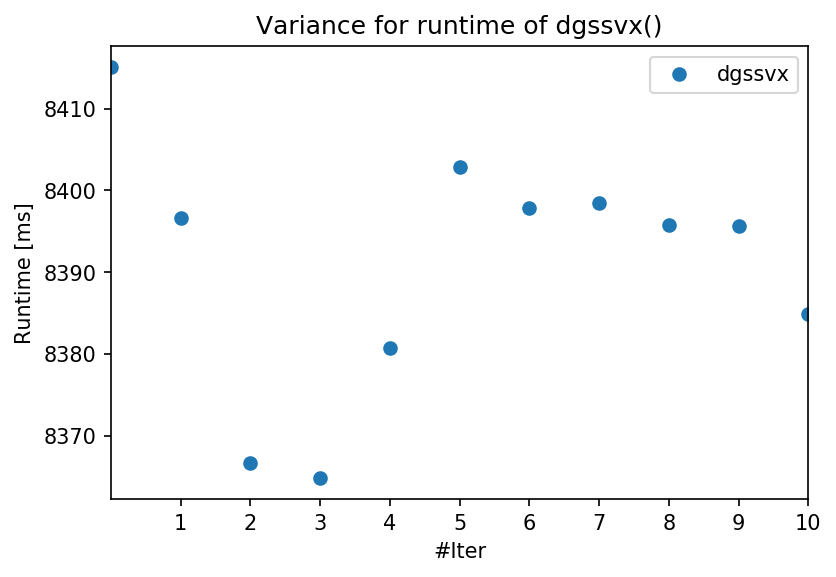

In [420]:
# Plot of the runtimes for all iterations of dgssvx()
a = (slu_nat_60F['dgssvx'])
ax = a.plot(style='o',title='Variance for runtime of dgssvx()')
plt.xticks(np.arange(1, 11, 1))
ax.set(xlabel="#Iter", ylabel="Runtime [ms]")
ax.legend(loc='best')
plt.show()

Let's gather the statistical values for the obtained timings (in ms) and memory consumption.

In [421]:
slu_nat_tstats = get_slu_stats(slu_nat_60F, 'dgssvx', 11)
slu_col_tstats = get_slu_stats(slu_col_60F, 'dgssvx', 11)
slu_ata_tstats = get_slu_stats(slu_ata_60F, 'dgssvx', 11)
slu_usa_tstats = get_slu_stats(slu_usa_60F, 'dgssvx', 11)

slu_nat_mstats = get_slu_mstats(slu_nat_60F)
slu_col_mstats = get_slu_mstats(slu_col_60F)
slu_ata_mstats = get_slu_mstats(slu_ata_60F)
slu_usa_mstats = get_slu_mstats(slu_usa_60F)

In [422]:
# Consturct DataFrame for nice output.
ind = ['Mean [ms]', 'Min [ms]', 'Max [ms]', 'Std [ms]', 'Total [MB]', 'L\U  [MB]']
d = {'NATURAL': slu_nat_tstats+ slu_nat_mstats,
     'COLAMD' : slu_col_tstats+ slu_col_mstats,
     'MMD_ATA' : slu_ata_tstats+ slu_ata_mstats,
     'MMD_AT_PLUS_A' : slu_usa_tstats+ slu_usa_mstats
    }
slu_tdf = pd.DataFrame(data=d, index=ind)
slu_tdf = slu_tdf[['COLAMD', 'NATURAL', 'MMD_ATA', 'MMD_AT_PLUS_A']] # Order columns in my way (not alphabetically)
print("Mean, max, min and standard deviation for dgssvx() over several repetitions for hqp3_60/Full")
slu_tdf

Mean, max, min and standard deviation for dgssvx() over several repetitions for hqp3_60/Full


,COLAMD,NATURAL,MMD_ATA,MMD_AT_PLUS_A
Mean [ms],216.397800,8388.44270,294.692600,747.133100
Min [ms],209.310000,8364.78200,291.420000,740.809000
Max [ms],222.801000,8402.90700,297.720000,750.655000
Std [ms],5.986307,13.64961,1.980908,2.766541
Total [MB],24.253000,254.67100,21.728000,36.507000
L\U [MB],12.966000,243.38400,10.441000,25.219000


In [423]:
slu_best_time = min(slu_col_tstats[0], slu_nat_tstats[0], slu_ata_tstats[0], slu_usa_tstats[0])
print("Best serial time [ms]: %s" % slu_best_time)

Best serial time [ms]: 216.3978


**Findings:**
* COLAMD, which is the default option, yields the fastest timings with reasonable small memory footprint
* MMD_ATA is a bit off with respect to timing, but has a little bit smaller memory footprint compared to COLAMD
* NATURAL is off in both statistics
* MMD_AT_PLUS_A is way off in timing, but reasonable in memory footprint

---

## SuperLU_MT

Read in the csv files holding the statistics.

In [424]:
slumt_col_60F = pd.read_csv(dir_60F+'/SuperLU_MT_COLAMD.csv',skipinitialspace=True)
slumt_ata_60F = pd.read_csv(dir_60F+'/SuperLU_MT_MMD_ATA.csv',skipinitialspace=True)
slumt_usa_60F = pd.read_csv(dir_60F+'/SuperLU_MT_MMD_AT_PLUS_A.csv',skipinitialspace=True)
# Did not work properly:
#slumt_nat = pd.read_csv('hqp3_60_Full_SuperLU_MT_NATURAL.csv',skipinitialspace=True)

In [425]:
# Convert timings to ms.
slumt_col_60F['pdgssvx'] = slumt_col_60F['pdgssvx'] / 1000
slumt_ata_60F['pdgssvx'] = slumt_ata_60F['pdgssvx'] / 1000
slumt_usa_60F['pdgssvx'] = slumt_usa_60F['pdgssvx'] / 1000

Gather timing statistics for SuperLU_MT: mean, std, min and max.

In [426]:
(threads, slumt_col_tstats) = get_slumt_stats(slumt_col_60F, 'pdgssvx', 11)
(threads, slumt_ata_tstats) = get_slumt_stats(slumt_ata_60F, 'pdgssvx', 11)
(threads, slumt_usa_tstats) = get_slumt_stats(slumt_usa_60F, 'pdgssvx', 11)

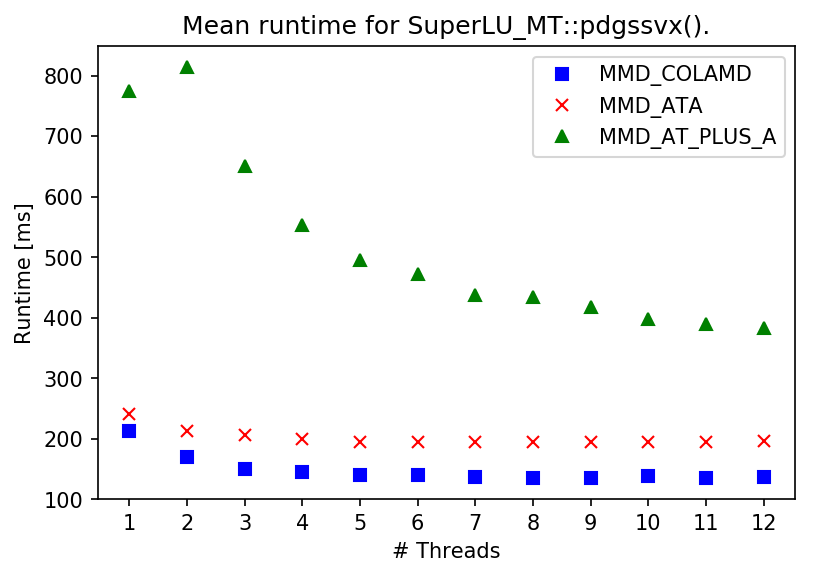

In [427]:
# All first items in slumt_col_tstats of type list(list)
#lst = [item[0] for item in slumt_col_tstats]
plt.plot(threads, [item[0] for item in slumt_col_tstats], 'bs', label="MMD_COLAMD" )
plt.plot(threads, [item[0] for item in slumt_ata_tstats], 'rx', label="MMD_ATA" )
plt.plot(threads, [item[0] for item in slumt_usa_tstats], 'g^', label="MMD_AT_PLUS_A" )
plt.xticks(np.arange(min(threads), max(threads)+1, 1))
plt.ylabel('Runtime [ms]')
plt.xlabel('# Threads')
legend = plt.legend(loc='best')
plt.title('Mean runtime for SuperLU_MT::pdgssvx().')
plt.show()

Have a look at the speedups for the various orderings.

In [428]:
sp_col = get_speedups(slumt_col_tstats, slu_best_time)
sp_ata = get_speedups(slumt_ata_tstats, slu_best_time)
sp_usa = get_speedups(slumt_usa_tstats, slu_best_time)

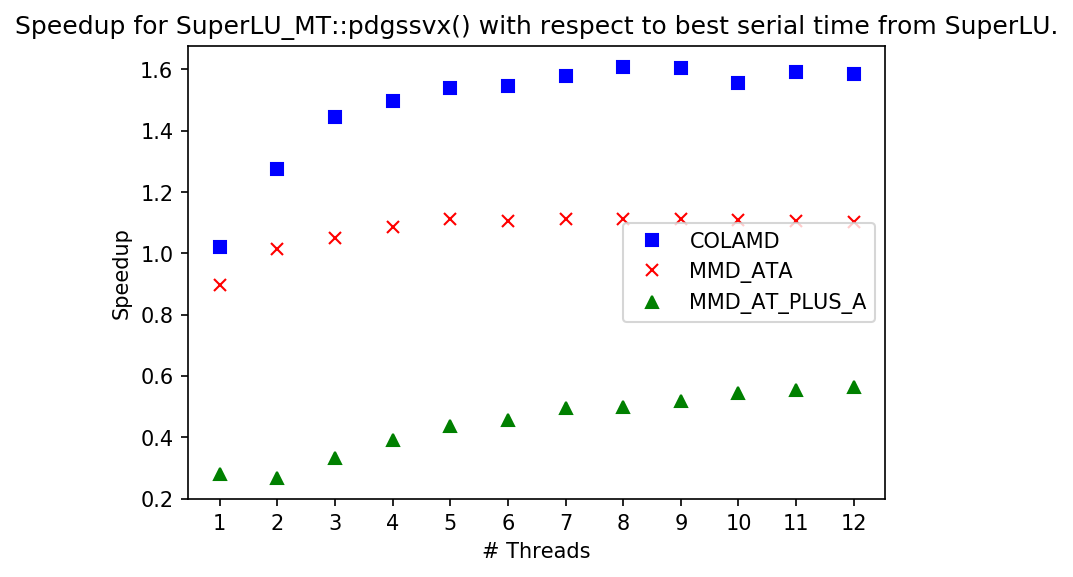

In [447]:
plt.plot(threads, sp_col, 'bs', label="COLAMD")
plt.plot(threads, sp_ata, 'rx', label="MMD_ATA")
plt.plot(threads, sp_usa, 'g^', label="MMD_AT_PLUS_A")
plt.xticks(np.arange(min(threads), max(threads)+1, 1))
plt.ylabel('Speedup')
plt.xlabel('# Threads')
legend = plt.legend(loc='best')
plt.title('Speedup for SuperLU_MT::pdgssvx() with respect to best serial time from SuperLU.')
plt.show()

Have a look at the total memory consumption for SuperLU_MT. Remark: The memory consumption for the L\U decomposition can be plotted the very same way. Since it also scales linear with the number of threads, we do not plot it. 

In [430]:
(_, slumt_col_mstats) = get_slumt_tstats(slumt_col_60F, 'Total MB', 11)
(_, slumt_ata_mstats) = get_slumt_tstats(slumt_ata_60F, 'Total MB', 11)
(_, slumt_usa_mstats) = get_slumt_tstats(slumt_usa_60F, 'Total MB', 11)

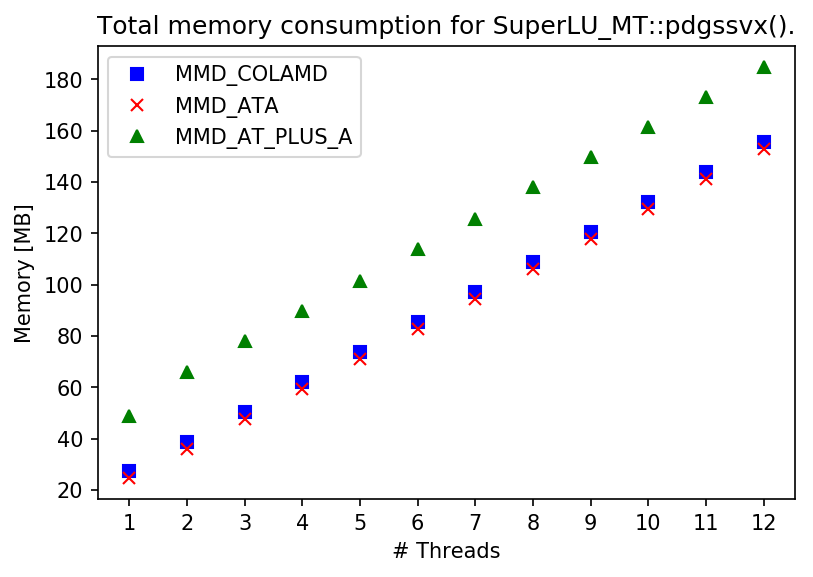

In [431]:
# All first items in slumt_col_tstats of type list(list)
#lst = [item[0] for item in slumt_col_tstats]
plt.plot(threads, [item[0] for item in slumt_col_mstats], 'bs', label="MMD_COLAMD" )
plt.plot(threads, [item[0] for item in slumt_ata_mstats], 'rx', label="MMD_ATA" )
plt.plot(threads, [item[0] for item in slumt_usa_mstats], 'g^', label="MMD_AT_PLUS_A" )
plt.xticks(np.arange(min(threads), max(threads)+1, 1))
plt.ylabel('Memory [MB]')
plt.xlabel('# Threads')
legend = plt.legend(loc='best')
plt.title('Total memory consumption for SuperLU_MT::pdgssvx().')
plt.show()

In [432]:
(th, slumt_best_time) = get_best_time(slumt_col_tstats, slumt_ata_tstats, slumt_usa_tstats)

print("Best SuperLU time [ms]:  %d  " % slu_best_time)
print("Best SuperLU_MT time [ms]: %d using %d threads" %(slumt_best_time, th))

Best SuperLU time [ms]:  216  
Best SuperLU_MT time [ms]: 134 using 7 threads


**Findings:**
* Ordering algorithm COLAMD yields the fastest timings to solve the system
  * It scales very reasonable up to 8 threads
* Memory consumption scales linear with the number of threads. This holds for all ordering algorithms.
  * MMD_AT_PLUS_A requests a (constant) additional amount of memory compared to COLAMD and MMD_ATA
* SuperLU_MT yields nearly a **speedup of factor 2** with respect to SuperLU!

----

## SuperLU_DIST

In [433]:
sludist_ata_60F = pd.read_csv(dir_60F+'/SuperLU_DIST_MMD_ATA.csv',skipinitialspace=True)
sludist_usa_60F = pd.read_csv(dir_60F+'/SuperLU_DIST_MMD_AT_PLUS_A.csv',skipinitialspace=True)
sludist_nat_60F = pd.read_csv(dir_60F+'/SuperLU_DIST_NATURAL.csv',skipinitialspace=True)

In [434]:
dfc_ata_60F = condense_df(sludist_ata_60F, 5)
dfc_usa_60F = condense_df(sludist_usa_60F, 5)
dfc_nat_60F = condense_df(sludist_nat_60F, 5)

**Todo** Different 2d grids result in the very same number of MPI procesess, like 2x3 and 3x2. Mark this in the following plot

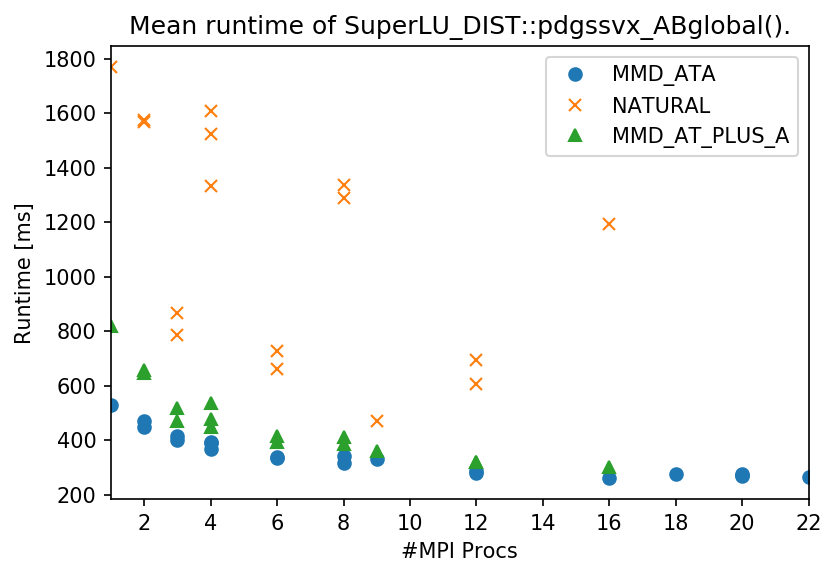

In [435]:
# Plot the timings for all three orderings into one figure.
loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
ax = dfc_ata_60F.plot(x='#MPI Procs', y='time', style='o', label="MMD_ATA")
ax.xaxis.set_major_locator(loc)
ax2 = dfc_nat_60F.plot(ax=ax, x='#MPI Procs', y='time', style='x',  label="NATURAL")
dfc_usa_60F.plot(ax=ax2, x='#MPI Procs', y='time', style='^', label="MMD_AT_PLUS_A")
ax2.set(xlabel="#MPI Procs", ylabel="Runtime [ms]")
legend = plt.legend(loc='best')
plt.title('Mean runtime of SuperLU_DIST::pdgssvx_ABglobal().')
plt.show()

From the previous figure, it is clear that ordering MMD_ATA yields the fastest runtimes for SuperLU_DIST. Thus, we will only analyse the results obtained with ordering MMD_ATA further.

In [436]:
# Find best runtime for SuperLU_DIST
#sludist_best_time = dfc_ata['time'].min()
#mi = dfc_ata['time'].idxmin() # Idx of minimal value in column 'time'
#nrows = dfc_ata['nrows'][mi]
#ncols = dfc_ata['ncols'][mi]
#nmpi = dfc_ata['#MPI Procs'][mi]

(sludist_best_time, descr)  = get_sludist_best_time(dfc_ata_60F)

print "===== SuperLU_DIST ====="
print "Best runtime: ", sludist_best_time, "ms"
print "  #MPI Procs: ", descr[0]
print "       #rows: ", descr[1]
print "       #cols: ", descr[2]

===== SuperLU_DIST =====
Best runtime:  258.772 ms
  #MPI Procs:  16
       #rows:  4
       #cols:  4


In [437]:
# Best runtimes for all benchmarks:
print "==== Best Runtimes for system hqp3_60/Full ===="
print "     SuperLU: ", slu_best_time, "ms"
print "  SuperLU_MT: ", slumt_best_time, "ms using %s threads" % th
print "SuperLU_DIST: ", sludist_best_time, "ms using %s MPI procesess" % descr[0]

==== Best Runtimes for system hqp3_60/Full ====
     SuperLU:  216.3978 ms
  SuperLU_MT:  134.4757 ms using 7 threads
SuperLU_DIST:  258.772 ms using 16 MPI procesess


### Findings
* SuperLU_MT outperforms SuperLU and SuperLU_DIST clearly
* Max. speedup achieved using SuperLU_MT 1.6 with respect to SuperLU
* SuperLU_DIST is even slower than sequential SuperLU


----

## hqp3_15/Full

### SuperLU

In [438]:
# Read in csv files holding the benchmark statistics.
slu_col_15F = pd.read_csv(dir_15F+'/SuperLU_COLAMD.csv', skipinitialspace=True)
slu_ata_15F = pd.read_csv(dir_15F+'/SuperLU_MMD_ATA.csv', skipinitialspace=True)
slu_usa_15F = pd.read_csv(dir_15F+'/SuperLU_MMD_AT_PLUS_A.csv', skipinitialspace=True)
# Did not succeed:
#slu_nat_15F = pd.read_csv(dir_15F+'/SuperLU_NATURAL.csv',skipinitialspace=True)

In [439]:
# Convert timings to ms.
slu_col_15F['dgssvx'] = slu_col_15F['dgssvx'] / 1000
slu_ata_15F['dgssvx'] = slu_ata_15F['dgssvx'] / 1000
slu_usa_15F['dgssvx'] = slu_usa_15F['dgssvx'] / 1000

In [440]:
slu_col_tstats = get_slu_stats(slu_col_15F, 'dgssvx', 11)
slu_ata_tstats = get_slu_stats(slu_ata_15F, 'dgssvx', 11)
slu_usa_tstats = get_slu_stats(slu_usa_15F, 'dgssvx', 11)

slu_col_mstats = get_slu_mstats(slu_col_15F)
slu_ata_mstats = get_slu_mstats(slu_ata_15F)
slu_usa_mstats = get_slu_mstats(slu_usa_15F)

In [441]:
# Consturct DataFrame for nice output.
ind = ['Mean [ms]', 'Min [ms]', 'Max [ms]', 'Std [ms]', 'Total [MB]', 'L\U  [MB]']
d = {'COLAMD' : slu_col_tstats+ slu_col_mstats,
     'MMD_ATA' : slu_ata_tstats+ slu_ata_mstats,
     'MMD_AT_PLUS_A' : slu_usa_tstats+ slu_usa_mstats }
slu_tdf = pd.DataFrame(data=d, index=ind)
slu_tdf = slu_tdf[['COLAMD', 'MMD_ATA', 'MMD_AT_PLUS_A']] # Order columns in my way (not alphabetically)
print("Mean, max, min and standard deviation for dgssvx() over several repetitions for hqp3_60/Full")
slu_tdf

Mean, max, min and standard deviation for dgssvx() over several repetitions for hqp3_60/Full


,COLAMD,MMD_ATA,MMD_AT_PLUS_A
Mean [ms],967.263300,1453.374400,28608.678900
Min [ms],962.073000,1442.519000,28562.534000
Max [ms],976.149000,1469.003000,28654.636000
Std [ms],4.522756,9.292374,29.348663
Total [MB],101.349000,91.991000,353.954000
L\U [MB],56.612000,47.254000,309.217000


In [442]:
slu_best_time_15F = min(slu_col_tstats[0], slu_ata_tstats[0], slu_usa_tstats[0])
print("Best serial time [ms]: %s" % slu_best_time_15F)

Best serial time [ms]: 967.2633


**Findings**
* COLAMD ordering algorithm yields fastest runtimes
* ATA ordering is slower but has smaller memory footprint compared to COLAMD
* AT_PLUS_A ordering is way off in both aspects runtime and memory footprint

----

### SuperLU_MT

In [443]:
slumt_col_15F = pd.read_csv(dir_15F+'/SuperLU_MT_COLAMD.csv',skipinitialspace=True)
slumt_ata_15F = pd.read_csv(dir_15F+'/SuperLU_MT_MMD_ATA.csv',skipinitialspace=True)
slumt_usa_15F = pd.read_csv(dir_15F+'/SuperLU_MT_MMD_AT_PLUS_A.csv',skipinitialspace=True)

In [444]:
# Convert timings to ms.
slumt_col_15F['pdgssvx'] = slumt_col_15F['pdgssvx'] / 1000
slumt_ata_15F['pdgssvx'] = slumt_ata_15F['pdgssvx'] / 1000
slumt_usa_15F['pdgssvx'] = slumt_usa_15F['pdgssvx'] / 1000

In [445]:
# Be careful, MMD_AT_PLUS_A was so slow, we just executed it for 1 MPI Process and skipped the rest
(threads, slumt_col_tstats) = get_slumt_stats(slumt_col_15F, 'pdgssvx', 11)
(threads, slumt_ata_tstats) = get_slumt_stats(slumt_ata_15F, 'pdgssvx', 11)
(_, slumt_usa_tstats) = get_slumt_stats(slumt_usa_15F, 'pdgssvx', 11)

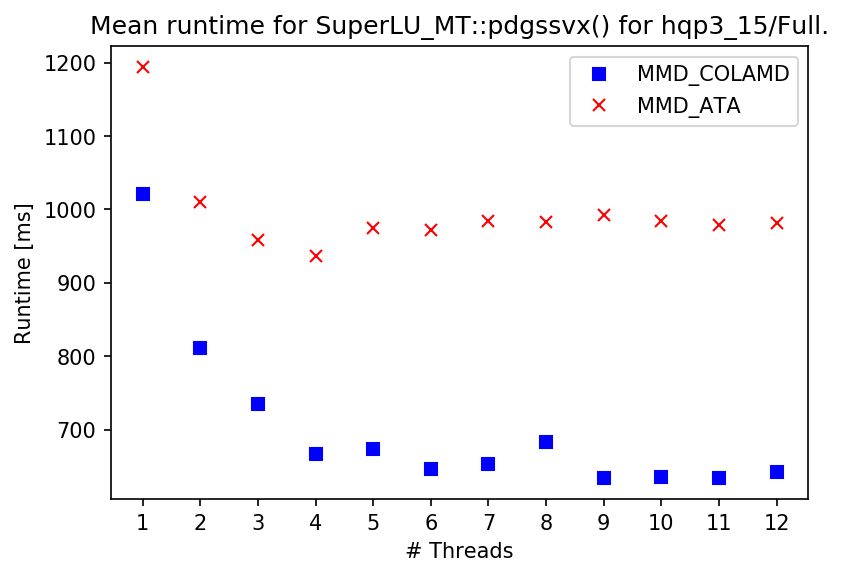

In [448]:
# All first items in slumt_col_tstats of type list(list)
#lst = [item[0] for item in slumt_col_tstats]
loc = plticker.MultipleLocator(base=2.0) # this locator puts ticks at regular intervals
plt.plot(threads, [item[0] for item in slumt_col_tstats], 'bs', label="MMD_COLAMD" )
plt.plot(threads, [item[0] for item in slumt_ata_tstats], 'rx', label="MMD_ATA" )
plt.xticks(np.arange(min(threads), max(threads)+1, 1))
plt.ylabel('Runtime [ms]')
plt.xlabel('# Threads')
legend = plt.legend(loc='best')
plt.title('Mean runtime for SuperLU_MT::pdgssvx() for hqp3_15/Full.')
plt.show()

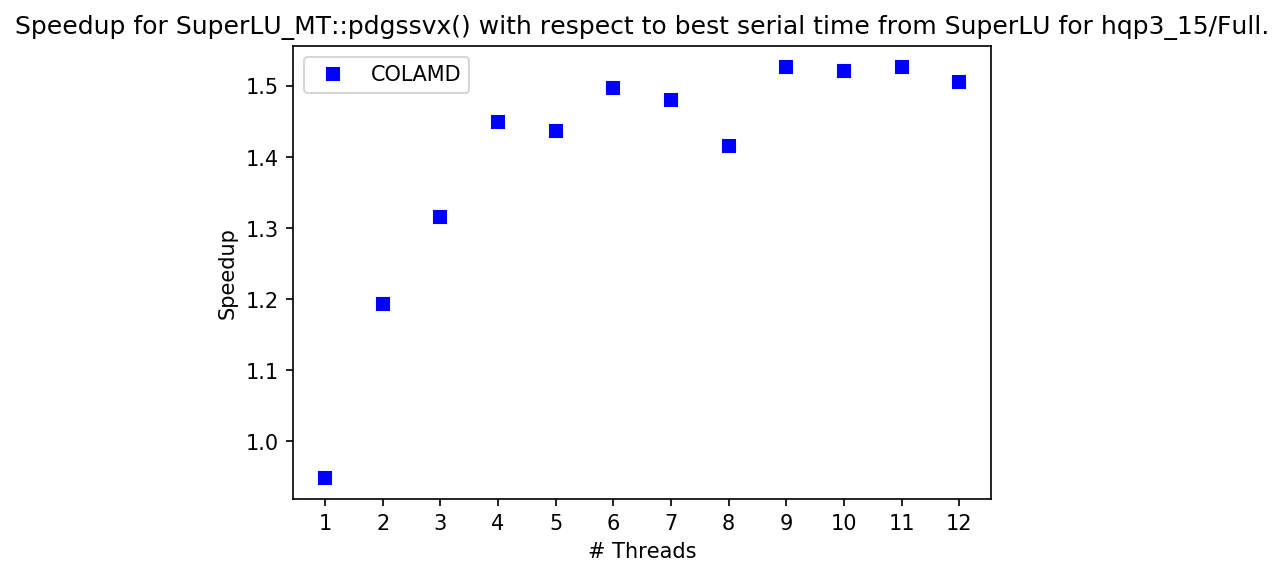

In [451]:
sp_col = get_speedups(slumt_col_tstats, slu_best_time_15F)
plt.plot(threads, sp_col, 'bs', label="COLAMD")
plt.xticks(np.arange(min(threads), max(threads)+1, 1))
plt.ylabel('Speedup')
plt.xlabel('# Threads')
legend = plt.legend(loc='best')
plt.title('Speedup for SuperLU_MT::pdgssvx() with respect to best serial time from SuperLU for hqp3_15/Full.')
plt.show()

In [ ]:
### SuperLU_DIST

In [452]:
sludist_ata_15F = pd.read_csv(dir_15F+'/SuperLU_DIST_MMD_ATA.csv',skipinitialspace=True)
sludist_usa_15F = pd.read_csv(dir_15F+'/SuperLU_DIST_MMD_AT_PLUS_A.csv',skipinitialspace=True)
sludist_nat_15F = pd.read_csv(dir_15F+'/SuperLU_DIST_NATURAL.csv',skipinitialspace=True)

IOError: File taurus_haswell/hqp3_15/Full/SuperLU_DIST_MMD_ATA.csv does not exist

----

Zwischenablage- brauchen wir das noch?

Boxplot of the timings for ordering COLAMD over all threads. This plot is not very usefull, is it?
It ca be seen some kind of scaling (but for this a plot of the speedup would be better) and that the variance of the inividual runs is very small.

In [ ]:
ax = sns.boxplot(x="#Threads", y="pdgssvx", data=slumt_col, showfliers=False)
sns.plt.show()

Boxplot for ordering COLAMD and 1 thread. Just as example.

In [ ]:
xx=slumt_col[1:11]
ax = sns.boxplot(x="#Threads", y="pdgssvx", data=xx)
sns.plt.show()

In [ ]:
#Boxplots https://matplotlib.org/examples/pylab_examples/boxplot_demo.html
spread = np.random.rand(50) * 100
center = np.ones(25) * 50
flier_high = np.random.rand(10) * 100 + 100
flier_low = np.random.rand(10) * -100
data = np.concatenate((spread, center, flier_high, flier_low), 0)
type(data)
# basic plot
#plt.boxplot(data)
#plt.show()

In [ ]:
# Since we have a scaled number of threads, we are only interested in mean timing in the first step
ind = range(1, 13)
d = {'Mean' : list(zip(*slumt_col_tstats))[0],
    # 'MMD_ATA' : slu_ata_tstats,
    # 'MMD_AT_PLUS_A' : slu_usa_tstats
    }
df = pd.DataFrame(data=d, index=ind)
#df = df[['COLAMD', 'MMD_ATA', 'MMD_AT_PLUS_A']] # Order columns in my way (not alphabetically)
df
